# Hong Kong Interbank Balance Plot

#### Imports

In [17]:
import pandas as pd
import requests
from requests.adapters import Retry, HTTPAdapter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
import sqlite3


#### Globals

In [18]:
START = '2018-01-01'
END = str(pd.Timestamp.today().date())


#### Utility Functions

In [19]:
def url(Y, M, D):
    return (
        'https://www.hkma.gov.hk/eng/'
        'data-publications-and-research/data-and-statistics/'
        f'daily-monetary-statistics/{Y}/{M}/ms-{Y}{M}{D}/')


In [20]:
def interbank_balance(date):
    try:
        Y, M, D = date.split('-')
        sess = requests.Session()
        sess.mount('https://', HTTPAdapter(max_retries=Retry(total=50, backoff_factor=0.1)))
        resp = sess.get(url(Y, M, D))
        print(f'fetching {date}')
        soup = BeautifulSoup(resp.content)
        table = soup.select_one(
            '#interbank-liquidity + div + div div.collapsibles-accordion-content div.template-table table')
        trs = table.select('tr')
        td = trs[1].select('td')[1]
        clean_text = td.text.replace('mn', '').replace(
            '百萬', '').replace(',', '').strip()
        return float(clean_text)
    except (AttributeError, ):
        return None


#### Tests

In [21]:
for date in ['2022-06-01', '2022-08-01']:
    ib = interbank_balance(date)
    print(date, ib)


fetching 2022-06-01
2022-06-01 319990.0
fetching 2022-08-01
2022-08-01 165158.0


#### Fetch

If connection is banned, wait for a while and run this cell again. Program will only re-download failed fetch.

In [22]:
dates = [str(d.date())
         for d in pd.date_range(START, END)]
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    for d in dates:
        cursor.execute(f"SELECT * from interbank where Date='{d}'")
        rows = cursor.fetchall()
        if len(rows) == 0:
            val = interbank_balance(d)
            val = val if val is not None else 'NULL'
            cursor.execute(f'INSERT OR REPLACE INTO interbank (Date, Balance) VALUES ("{d}", {val})')
    conn.commit()

#### Plot

<Axes: title={'center': 'Hong Kong Interbank Balalnce'}, ylabel='million HKD'>

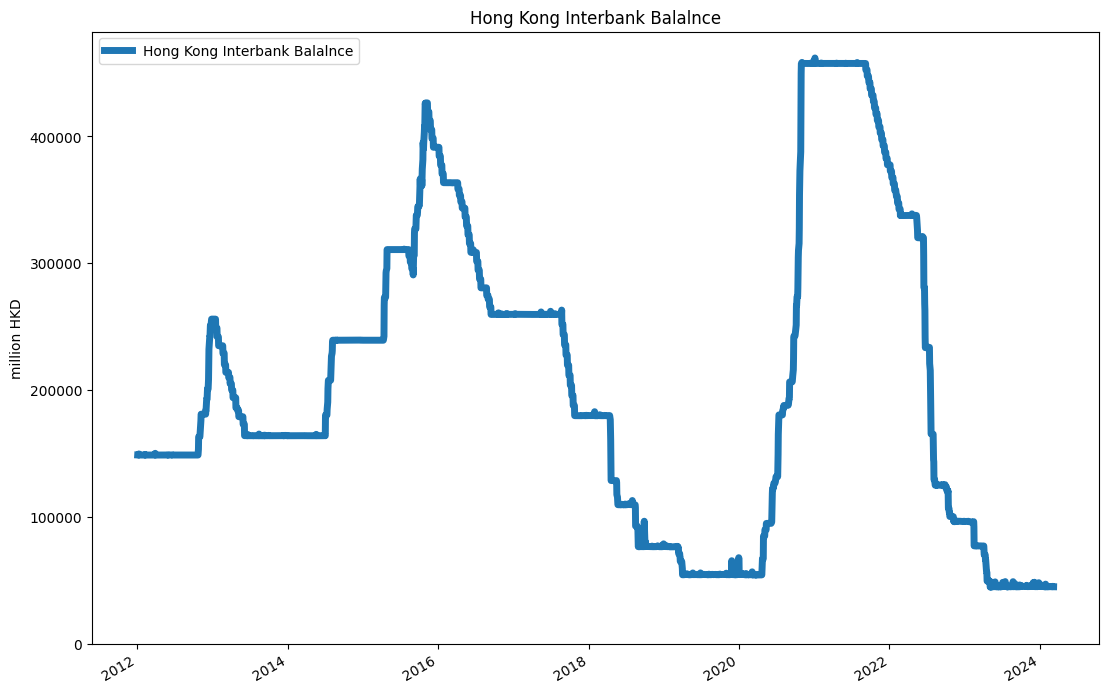

In [23]:
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT * from interbank')
    data = cursor.fetchall()

clean = {d: v for d, v in dict(data).items() if v}
series = pd.Series(clean.values(),
                   index=pd.to_datetime(list(clean.keys())),
                   name='Hong Kong Interbank Balalnce').sort_index()
fig, ax = plt.subplots(1, 1, figsize=(13, 9))
series.plot(ax=ax, ylim=(0, None), title=series.name,
            legend=series.name, ylabel='million HKD', lw=5)


#### Recent

In [24]:
series.sort_index().iloc[-20:]

2024-02-08    44706
2024-02-09    44706
2024-02-14    44893
2024-02-15    44893
2024-02-16    44893
2024-02-19    44893
2024-02-20    44928
2024-02-21    44776
2024-02-22    44857
2024-02-23    44861
2024-02-26    44909
2024-02-27    44929
2024-02-28    44785
2024-02-29    44785
2024-03-01    44785
2024-03-04    45105
2024-03-05    44791
2024-03-06    44774
2024-03-07    44774
2024-03-08    44781
Name: Hong Kong Interbank Balalnce, dtype: int64